In [31]:
import numpy as np
import pandas as pd
from scipy import stats
import pynapple as nap
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter, rotate
from scipy.stats import zscore

from spatial_manifolds.data.binning import get_bin_config
from spatial_manifolds.data.loading import load_session
from spatial_manifolds.util import gaussian_filter_nan

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
# weird behaviour from this example
mouse = 25
day = 19

In [33]:
session_type = 'OF1'
sorter = 'kilosort4'
storage = Path('/Users/harryclark/Downloads/COHORT12_nolfp/')
alpha = 0.001
n_jobs = 8
n_shuffles = 100
seed = 1

class Args:
    def __init__(self,mouse,day,session_type,sorter,storage,alpha,n_jobs,n_shuffles,seed):
        self.mouse = mouse
        self.day = day
        self.session_type = session_type
        self.sorter = sorter
        self.storage = storage
        self.alpha = alpha
        self.n_jobs = n_jobs
        self.n_shuffles = n_shuffles
        self.seed = seed
args = Args(mouse,day,session_type,sorter,storage,alpha,n_jobs,n_shuffles,seed)



In [34]:
# Load session
session, session_path, neurons = load_session(args)
tuning_scores = {
    path.with_suffix('').name: pd.read_parquet(path)
    for path in (session_path / 'tuning_scores').iterdir()
}
list(tuning_scores)

['hd_mean_vector_length',
 'grid_score',
 'theta_index',
 'speed_correlation',
 'ellipse_grid_score',
 'spatial_information']

In [39]:
cluster_ids_ordered = np.array(tuning_scores['grid_score'].sort_values(by='grid_score', ascending=False, na_position='last')['cluster_id'])

ENTm1_neurons = neurons[neurons.brain_region == 'ENTm1'] # be specific to a location
ENTm1_neurons = neurons[(neurons.coord_probe_y < 1200) & (neurons.coord_probe_y > 500)] # be specific to a location

bin_config = get_bin_config(session_type)[('P_x', 'P_y')]

neurons = neurons[(neurons.coord_probe_y > 500)] # be specific to a location
cluster_ids = neurons.index[::5][:-2]
tcs = {}
for index in cluster_ids:    
    neuron = neurons[neurons.index == index]
    print(neuron.coord_probe_y)
    tc = nap.compute_2d_tuning_curves(
        neuron,
        np.stack([session['P_x'], session['P_y']], axis=1),
        nb_bins=bin_config['num_bins'],
        minmax=bin_config['bounds'],
        ep=session['moving']
        )[0][index]
    tc = gaussian_filter_nan(
        tc,
        sigma=(2, 2),
        )
    tcs[index] = tc
    

71    945.0
Name: coord_probe_y, dtype: float64
97    1230.0
Name: coord_probe_y, dtype: float64
116    1410.0
Name: coord_probe_y, dtype: float64
131    1530.0
Name: coord_probe_y, dtype: float64
143    1605.0
Name: coord_probe_y, dtype: float64
151    1665.0
Name: coord_probe_y, dtype: float64
166    1740.0
Name: coord_probe_y, dtype: float64
176    1755.0
Name: coord_probe_y, dtype: float64
212    1935.0
Name: coord_probe_y, dtype: float64
253    2115.0
Name: coord_probe_y, dtype: float64


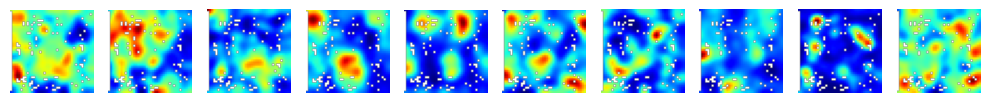

In [38]:
# Plot
ncols = 10
nrows = int(np.ceil(len(tcs)/ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, 
                       figsize=(10, 3*(np.ceil(len(tcs)/6)/4)), squeeze=False)
counter = 0
for j in range(nrows):
    for i in range(ncols):
        if counter<len(cluster_ids):
            index = cluster_ids[counter]
            ax[j, i].imshow(tcs[index], cmap='jet')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        ax[j, i].xaxis.set_visible(False)
        ax[j, i].yaxis.set_visible(False)
        ax[j, i].spines['top'].set_visible(False)
        ax[j, i].spines['right'].set_visible(False)
        ax[j, i].spines['bottom'].set_visible(False)
        ax[j, i].spines['left'].set_visible(False)
        ax[j, i].xaxis.set_tick_params(labelbottom=False)
        ax[j, i].yaxis.set_tick_params(labelleft=False)
        counter+=1
plt.tight_layout()
plt.show()
fig.savefig('/Users/harryclark/Downloads/M25_D19_MECl1_of_frm.pdf')
